In [1]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import os
import re
from matplotlib import colors

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True) #add flag force_remount = True if needed

In [3]:
!cp -rf "/content/drive/MyDrive/LDA/News.zip" .
!cp -rf "/content/drive/MyDrive/LDA/Headline.zip" .
!unzip -q News.zip
!unzip -q Headline.zip

In [21]:
#df = pd.read_json('News_Category_Dataset_v3.json', orient = 'records', lines = True)
#df[['headline', 'category', 'short_description']].head()
df = pd.read_csv('abcnews-date-text.csv')
df.head()

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers


In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stopwordset = set(stopwords.words())

In [6]:
def preprocess(text):
  le=WordNetLemmatizer()
  word_tokens=word_tokenize(text)
  tokens=[le.lemmatize(w) for w in word_tokens if w not in stopwordset]
  cleaned_text=" ".join(tokens)
  return cleaned_text

In [22]:
df['head_clean']=df['headline_text'].apply(preprocess)

In [8]:
df.sample(10)

,publish_date,headline_text,head_clean
264773,20061019,playground death under investigation,playground death investigation
854946,20140220,liberal leader tight lipped on interstate dash...,liberal leader tight lipped interstate dash fe...
449718,20090316,doctor to face court over child porn allegations,doctor court child porn allegation
1237638,20210620,police release footage of getaway cars used after,police release footage getaway car
1136273,20180801,fact check tax cuts women,fact check tax cut woman
499828,20091110,abc business news and market analysis,abc business news market analysis
342842,20071109,labor plan could drive public servants to private,labor plan drive public servant private
862550,20140325,burns allegations still baseless morrison,burn allegation baseless morrison
830647,20131031,nrn fruit quarantine,nrn fruit quarantine
1207768,20200727,ann vanstone announced as new commissioner aga...,ann vanstone announced commissioner corruption


In [9]:
df.shape


(1244184, 3)

In [23]:
orig_df = df
df.drop(['headline_text'], axis=1, inplace=True)
df.head()

,publish_date,head_clean
0,20030219,aba decides community broadcasting licence
1,20030219,act fire witness aware defamation
2,20030219,g call infrastructure protection summit
3,20030219,air nz staff aust strike pay rise
4,20030219,air nz strike affect australian traveller


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
tfidf = TfidfVectorizer(stop_words=list(stopwordset), max_features=5000)

#vect_text=vect.fit_transform(df['clean_combined'])
doctermmat=tfidf.fit_transform(df['head_clean'])
idf = tfidf.idf_
doctermmat

In [13]:
from sklearn.decomposition import LatentDirichletAllocation

lda_model=LatentDirichletAllocation(n_components=6,learning_method='online',max_iter=10) 
lda_top=lda_model.fit_transform(doctermmat)
print(lda_top.shape) 
lda_top

(1244184, 6)


array([[0.06930384, 0.06930384, 0.65348079, 0.06930384, 0.06930384,
        0.06930384],
       [0.05234013, 0.73825205, 0.05234013, 0.05238741, 0.05234014,
        0.05234013],
       [0.53621016, 0.05604125, 0.05604125, 0.23962486, 0.05604125,
        0.05604125],
       ...,
       [0.18892046, 0.05677026, 0.21365076, 0.26605699, 0.05606623,
        0.2185353 ],
       [0.05621846, 0.23816021, 0.05621846, 0.32956071, 0.05621847,
        0.26362369],
       [0.05179969, 0.05179969, 0.3037688 , 0.35590126, 0.18493088,
        0.05179969]])

In [14]:
print("Document 2: ")
for i, prob in enumerate(lda_top[2]):
  print("Topic ", i, ": ", prob)

Document 2: 
Topic  0 :  0.5362101571034958
Topic  1 :  0.05604124561878456
Topic  2 :  0.05604124515957719
Topic  3 :  0.23962486047241252
Topic  4 :  0.05604124602479984
Topic  5 :  0.056041245620930026


In [15]:
vocabulary = tfidf.get_feature_names_out()

for i, j in enumerate(lda_model.components_):
    zipped = zip(vocabulary, j)
    sorted_words = sorted(zipped, key = lambda x:x[1], reverse=True)[:10]
    print("Topic "+ str(i) + ": ")
    for word in sorted_words:
        print(word[0], end = " ")
    print()

Topic 0: 
australian call queensland day rural national open wa farmer canberra state win donald set indigenous sex power live funding nsw 

Topic 1: 
court death world south fire hospital north country tasmania charge show life cup china murder labor former west plan high 

Topic 2: 
interview police trump home car qld coast adelaide abc market crash cut melbourne gold road community service make driver victim 

Topic 3: 
australia covid election year charged found 19 police brisbane accused missing rise dead island deal record flood price leader royal 

Topic 4: 
woman government case child school change perth final killed student afl work protest speaks bushfire drum review darwin future climate 

Topic 5: 
coronavirus sydney news health report hit attack business minister house time victoria ban budget return water nt green centre resident 



In [24]:
results_sample = orig_df.sample(20)
topics = []

for idx in results_sample.index:
  topicstr = ''
  for i, prob in enumerate(lda_top[idx]):
    if prob >= 0.2:
      topicstr += ('Topic ' + str(i) + ": " + str(prob)[:5] + " ")
  
  topics.append(topicstr)

results_sample['topics'] = topics
results_sample

,publish_date,head_clean,topics
712372,20120801,customer seek time pay power bill,Topic 0: 0.273 Topic 1: 0.310 Topic 5: 0.269
724932,20120917,capital hill wednesday 12 september,
412819,20080924,alp losing ground state newspoll,Topic 1: 0.220 Topic 4: 0.231 Topic 5: 0.242
1068489,20170203,million dollar territory dundee boat ramp unus...,Topic 5: 0.214
171142,20050622,bronco bag,Topic 2: 0.371 Topic 4: 0.352
1087155,20170623,pizzagate gunman sentenced jail,Topic 4: 0.294 Topic 5: 0.461
373356,20080330,energy dimmed earth hour,Topic 0: 0.263 Topic 2: 0.247 Topic 3: 0.305
5851,20030319,king target crocs turner,Topic 4: 0.385 Topic 5: 0.390
685069,20120404,israel palestine peace talk resume,Topic 3: 0.582
88498,20040503,scientist wa qualified technician,Topic 0: 0.322 Topic 2: 0.399


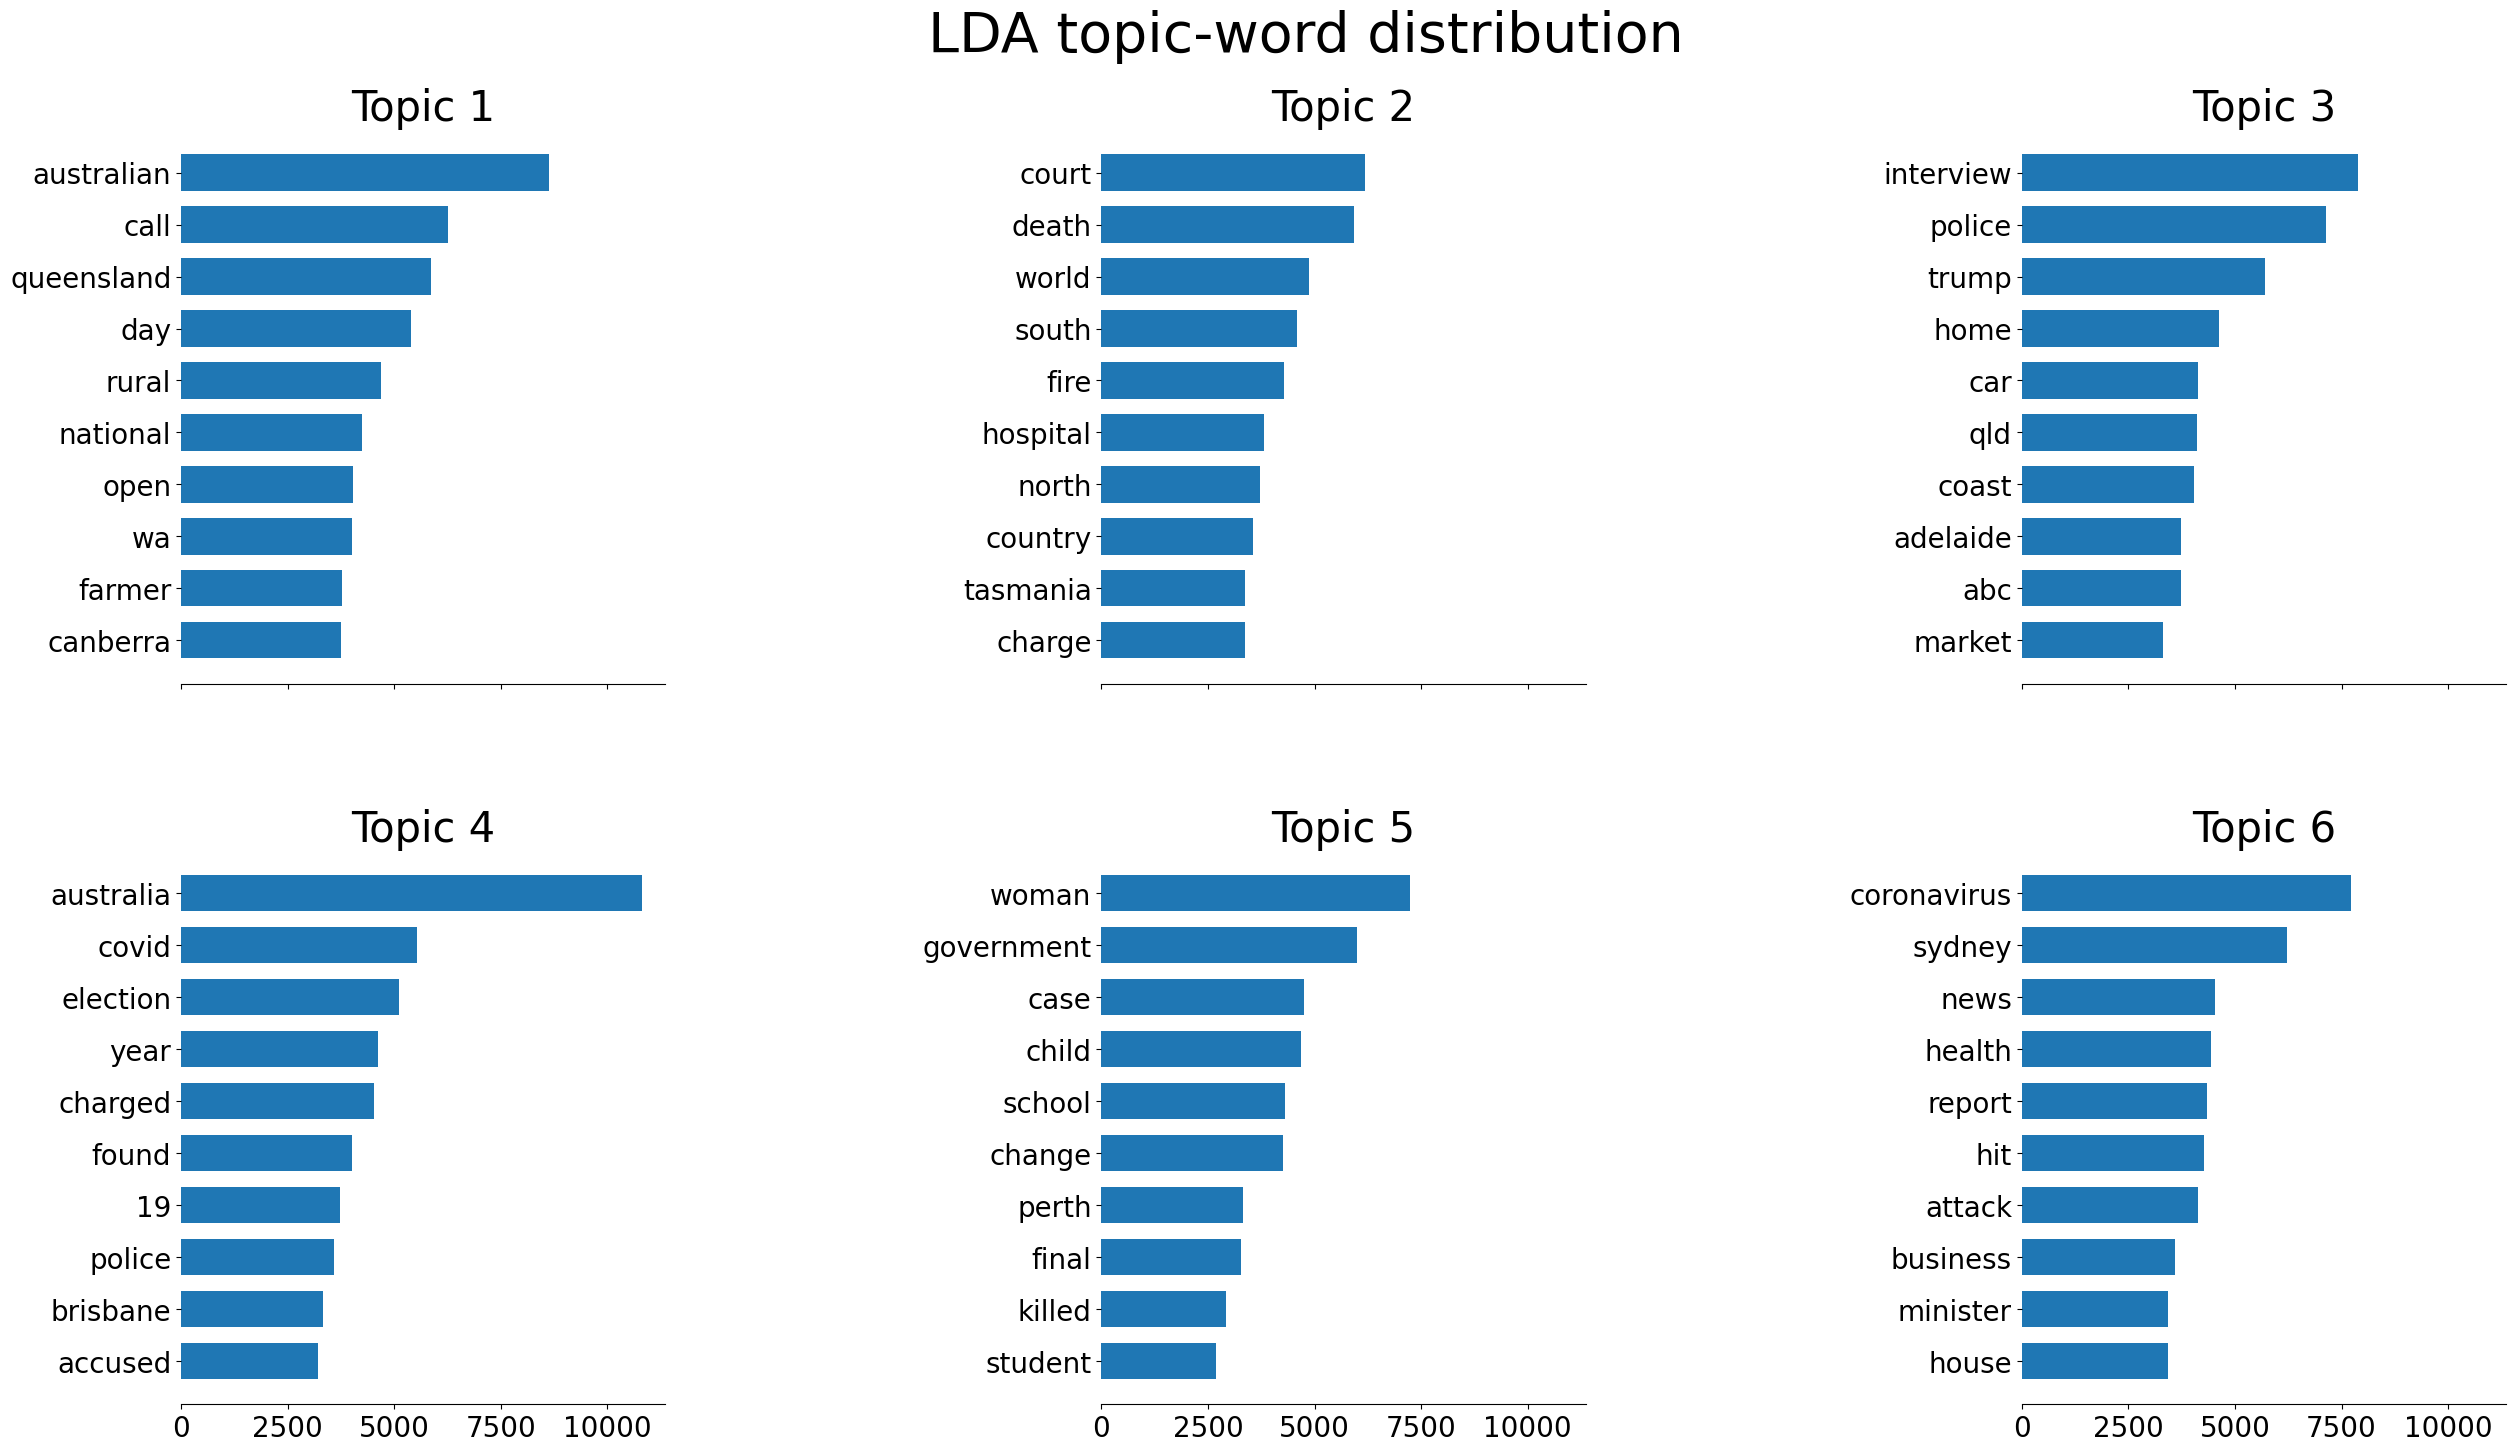

In [17]:
import matplotlib.pyplot as plt

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 3, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

tfidf_feature_names = tfidf.get_feature_names_out()
plot_top_words(lda_model, tfidf_feature_names, 10, 'LDA topic-word distribution')

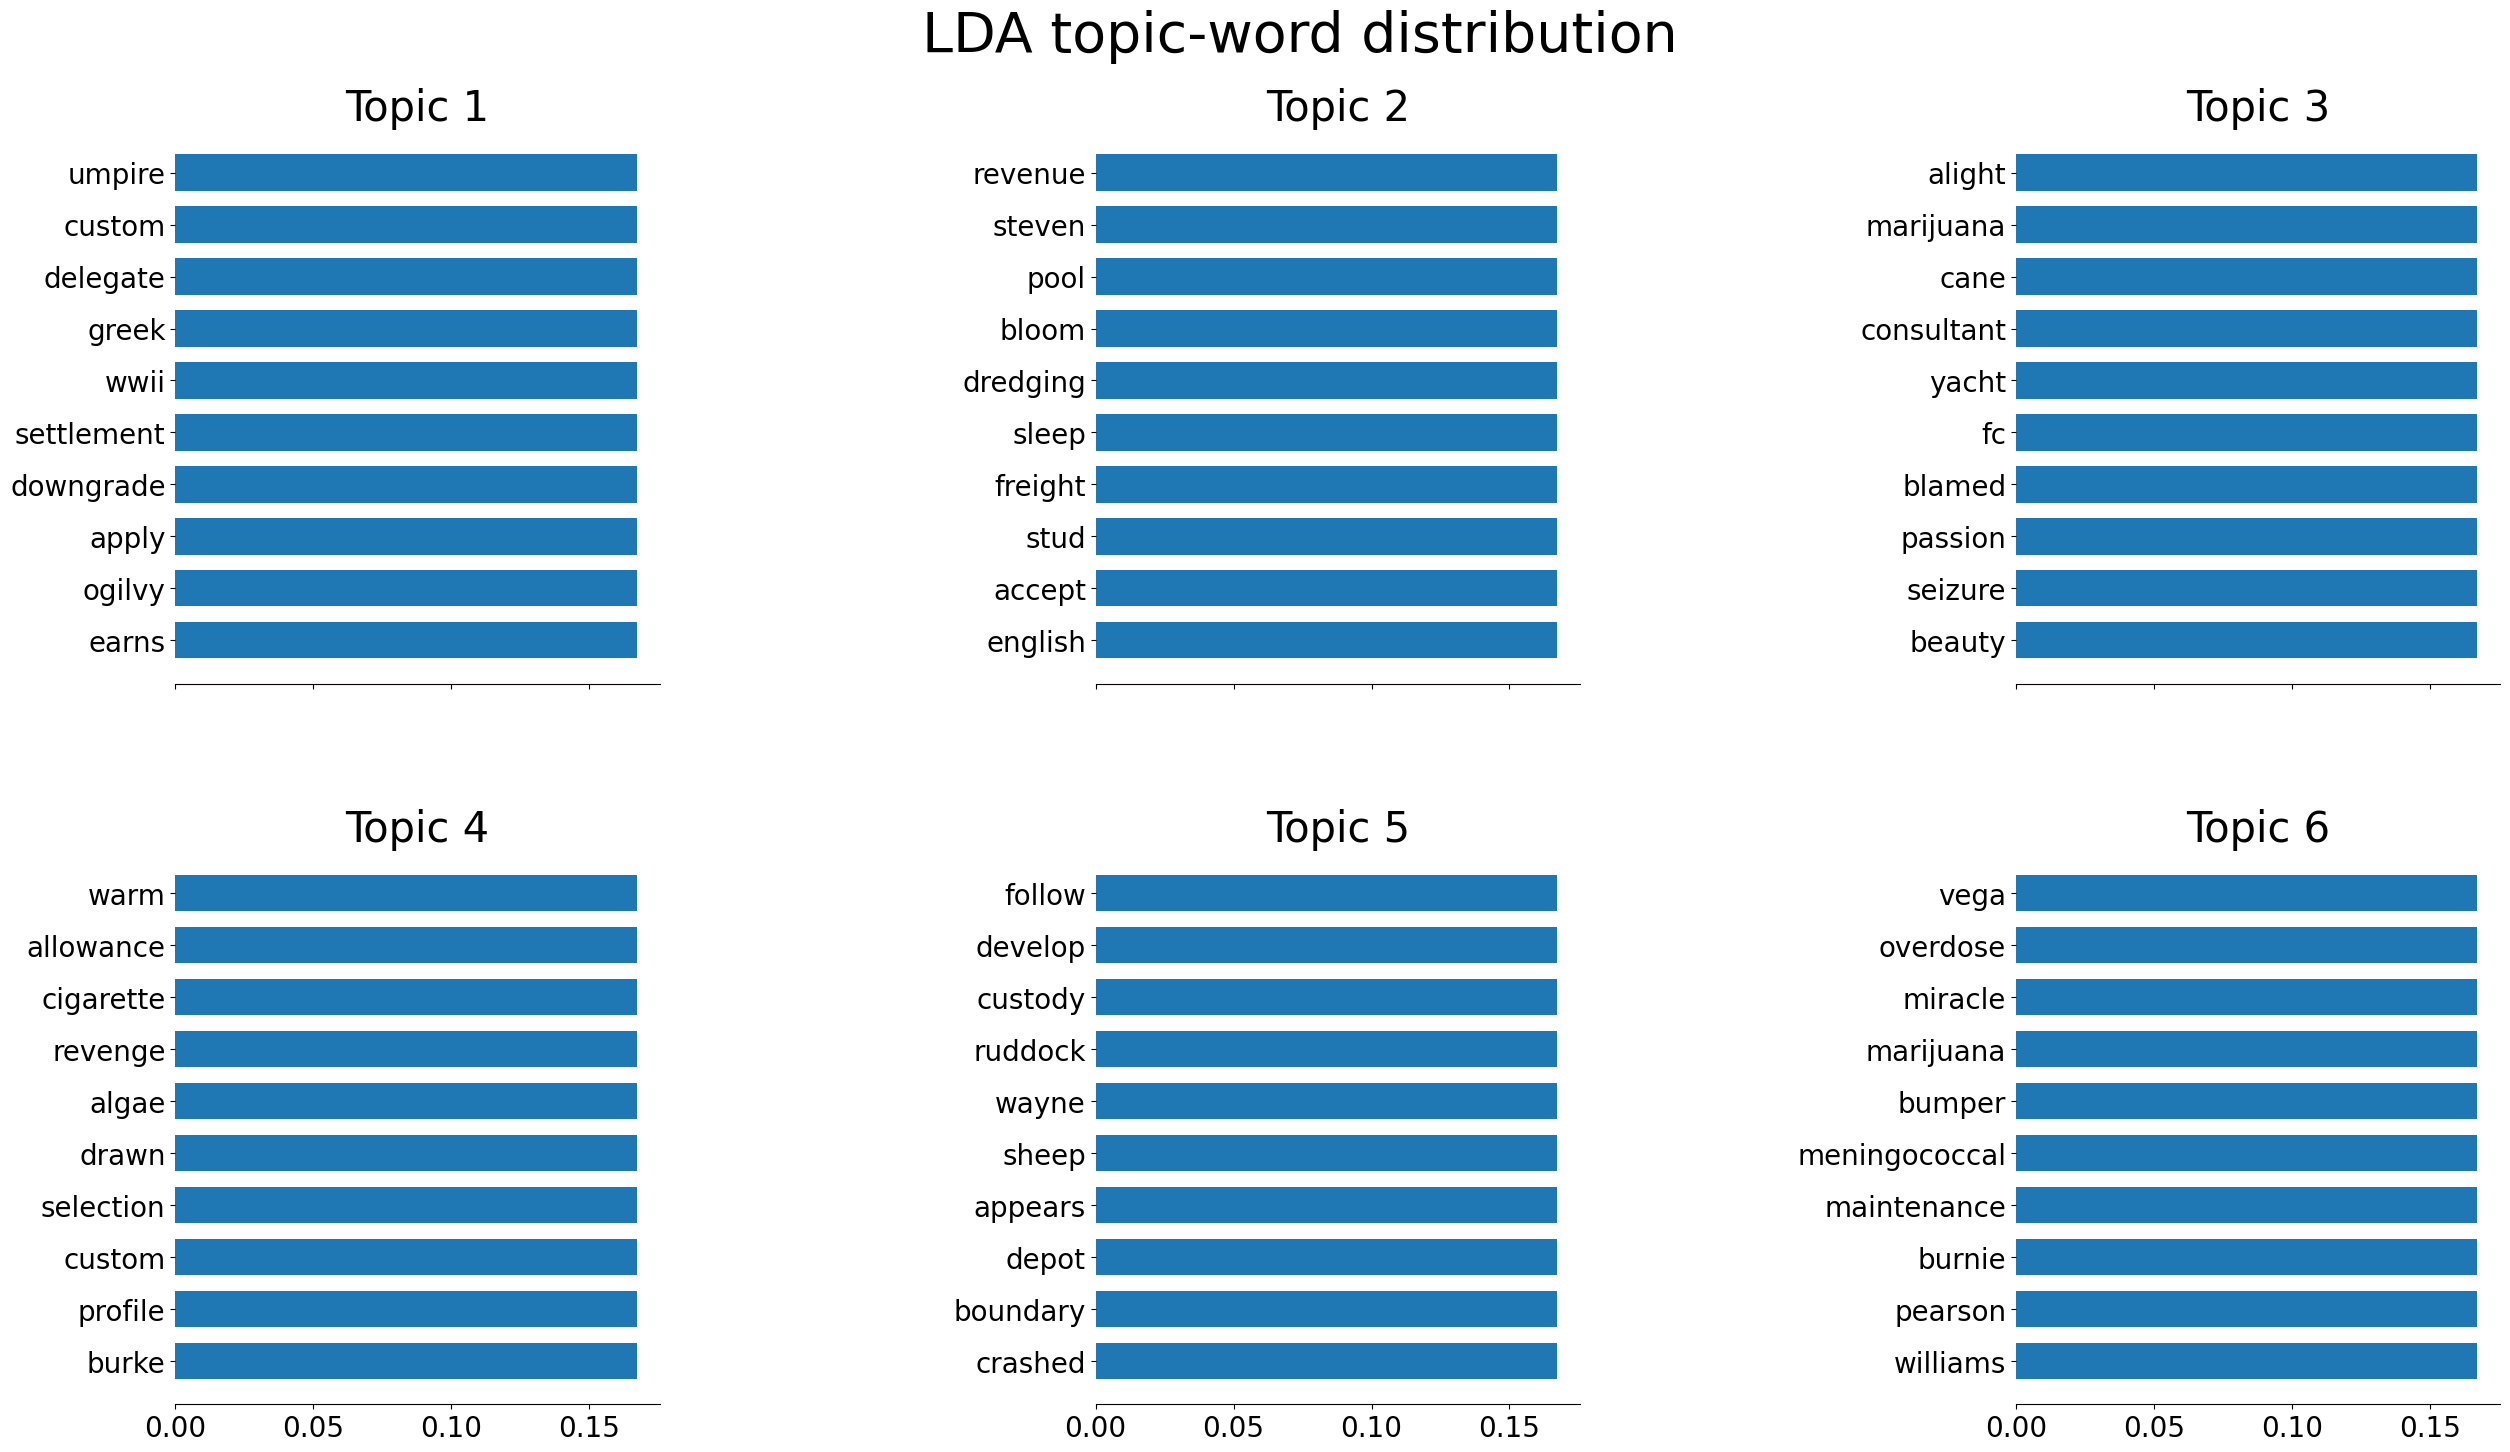

In [20]:
def plot_bot_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 3, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[1000:1000+n_top_words]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

tfidf_feature_names = tfidf.get_feature_names_out()
plot_bot_words(lda_model, tfidf_feature_names, 10, 'LDA topic-word distribution')